# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to classify an image as a certain label. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

**Remarks:** For some reason the code seems to fail when using the `Xception` architecture. `ResNet` for example, works fine though.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, load_class_names, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-09-28_Lab_Madrid_CopaBor_FondoBlanco_Xception_100ep'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W0928 12:03:22.202652 140252693964608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0928 12:03:22.204809 140252693964608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0928 12:03:22.206440 140252693964608 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loading class names...


Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Guided backprop](https://arxiv.org/abs/1412.6806)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)
* [Visual backprop](https://arxiv.org/abs/1611.05418)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

In [3]:
cd ..

/srv/image-classification-tf


[1/4] GradientSaliency
[2/4] GuidedBackprop


W0928 08:31:30.130023 140204491355968 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:60: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0928 08:31:43.559957 140204491355968 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:69: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0928 08:31:43.562850 140204491355968 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:70: The name tf.train.export_meta_graph is deprecated. Please use tf.compat.v1.train.export_meta_graph instead.

W0928 08:31:44.080978 140204491355968 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:72: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0928 08:31:47.327727 14020449135596

[3/4] IntegratedGradients
[4/4] VisualBackprop


ValueError: operands could not be broadcast together with shapes (1,34,34,1) (1,33,33,1) 

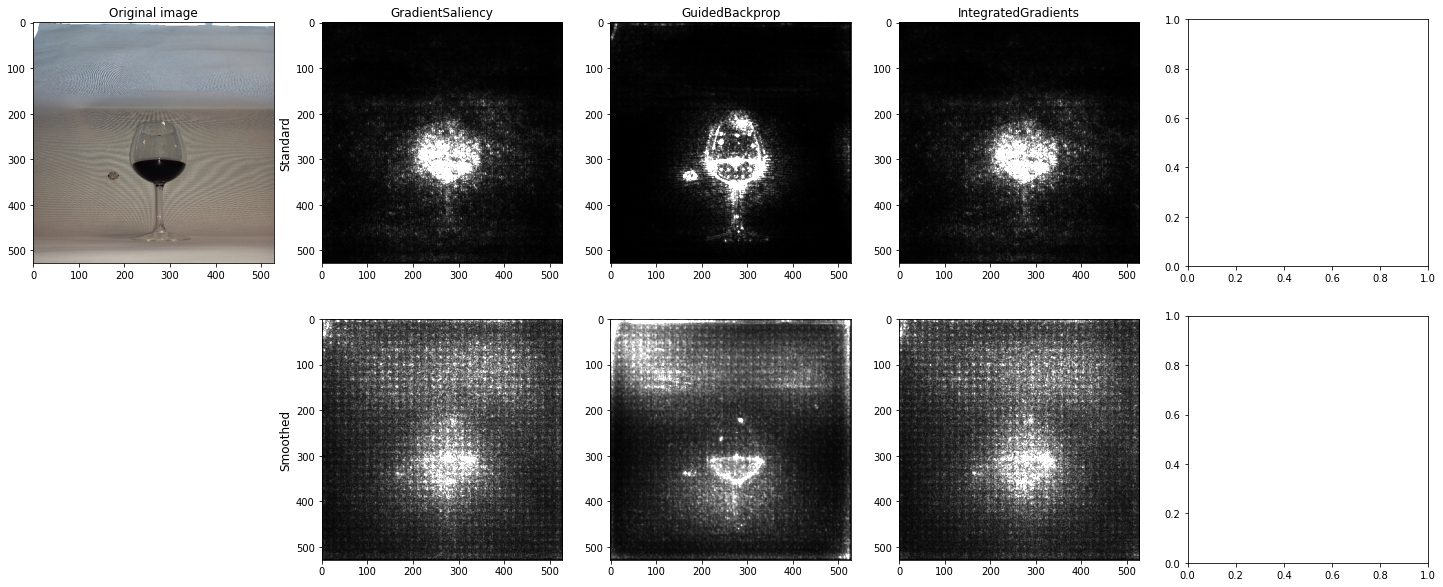

In [3]:
FILEPATH = 'data/images/Est_Mad_J_Bor_100_nd_f_bl_con_al_inf.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Top predicted labels:
[96.6%] 100mL
[3.3%] 150mL


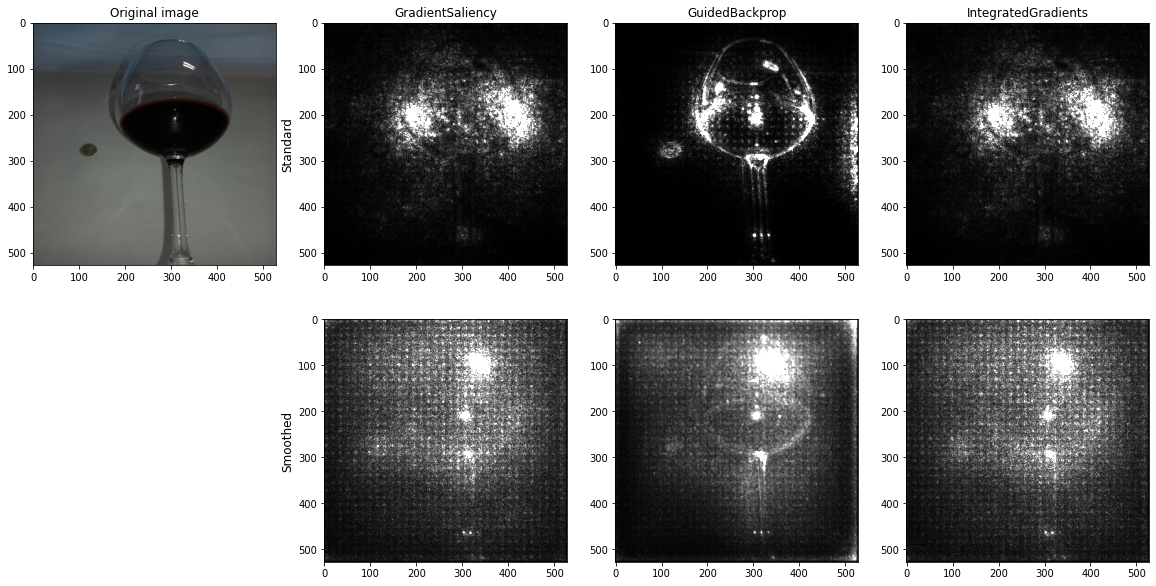

In [6]:
FILEPATH = 'data/images/Est_Mad_J_Bor_75_nd_f_bl_con_ce_inf.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Top predicted labels:
[99.4%] 100mL
[0.6%] 50mL


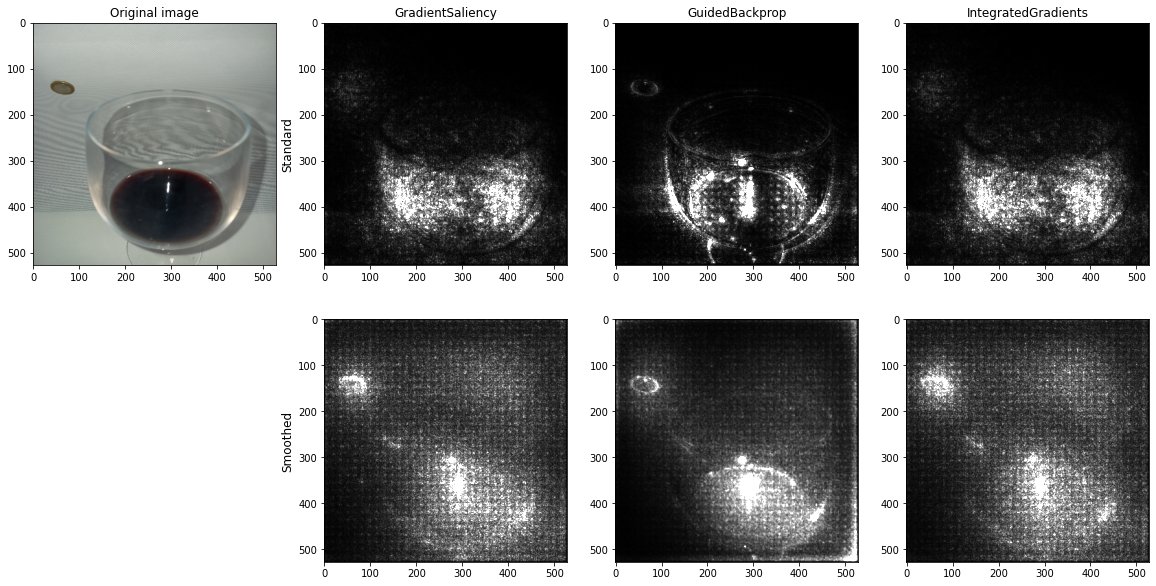

In [7]:
FILEPATH = 'data/images/Est_Mad_J_Bor_75_nd_f_bl_con_ce_sup.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop
[3/3] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Top predicted labels:
[97.5%] 200mL
[2.0%] 150mL


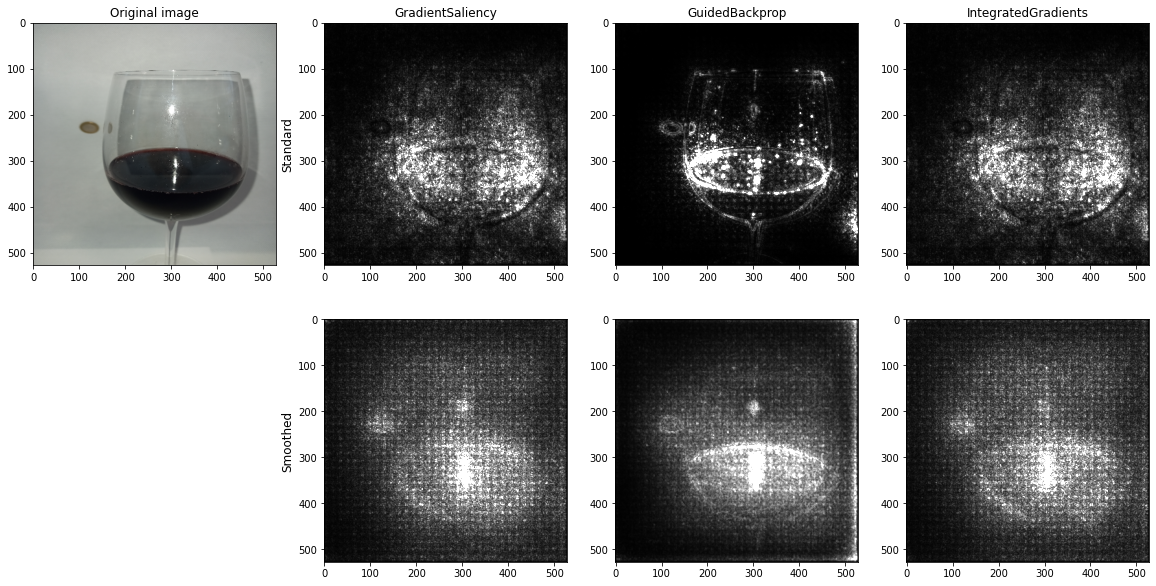

In [10]:
FILEPATH = 'data/images/Est_Mad_J_Bor_175_nd_f_bl_con_ce_cen.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop


W0928 08:52:58.879983 140091071313728 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:60: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0928 08:53:12.771902 140091071313728 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:69: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0928 08:53:12.773812 140091071313728 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:70: The name tf.train.export_meta_graph is deprecated. Please use tf.compat.v1.train.export_meta_graph instead.

W0928 08:53:13.291751 140091071313728 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:72: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0928 08:53:16.537430 14009107131372

[3/3] IntegratedGradients
1/1 [==============================] - 6s 6s/step
Top predicted labels:
[52.7%] 300mL
[20.5%] 200mL


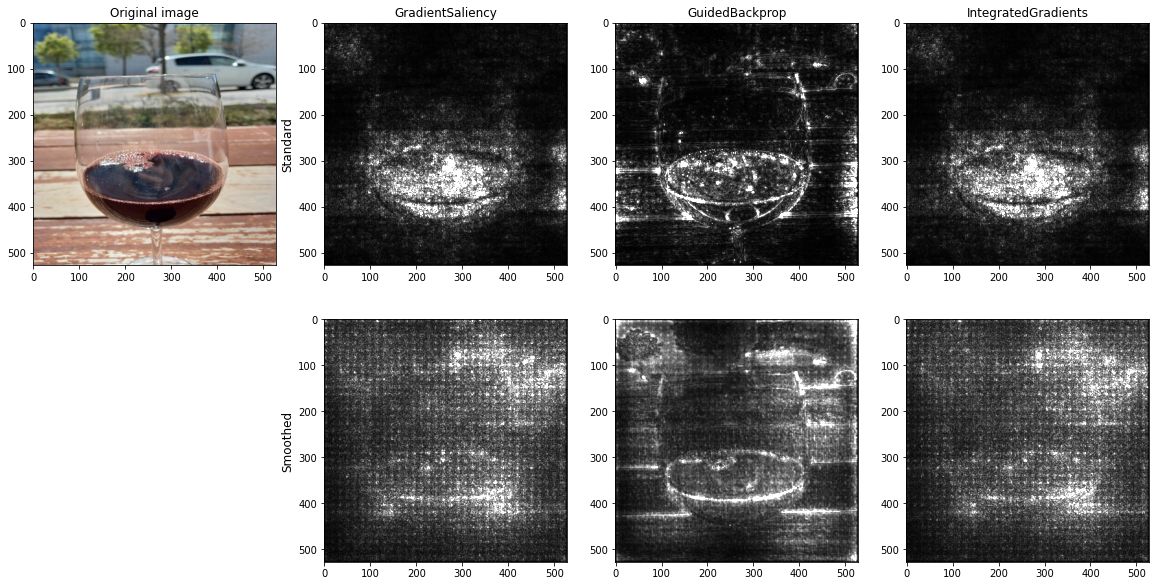

In [3]:
FILEPATH = '/srv/datos/Laboratorio/Madrid/copa Bor/Exterior/Est_Mad_J_Bor_175_nd_ext_nd_nd_ce_cen.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop


W0928 10:34:33.157987 139697914767168 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:60: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0928 10:34:47.039000 139697914767168 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:69: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0928 10:34:47.041049 139697914767168 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:70: The name tf.train.export_meta_graph is deprecated. Please use tf.compat.v1.train.export_meta_graph instead.

W0928 10:34:47.882504 139697914767168 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:72: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0928 10:34:50.795421 13969791476716

[3/3] IntegratedGradients
1/1 [==============================] - 5s 5s/step
Top predicted labels:
[98.2%] 300mL
[1.0%] 250mL


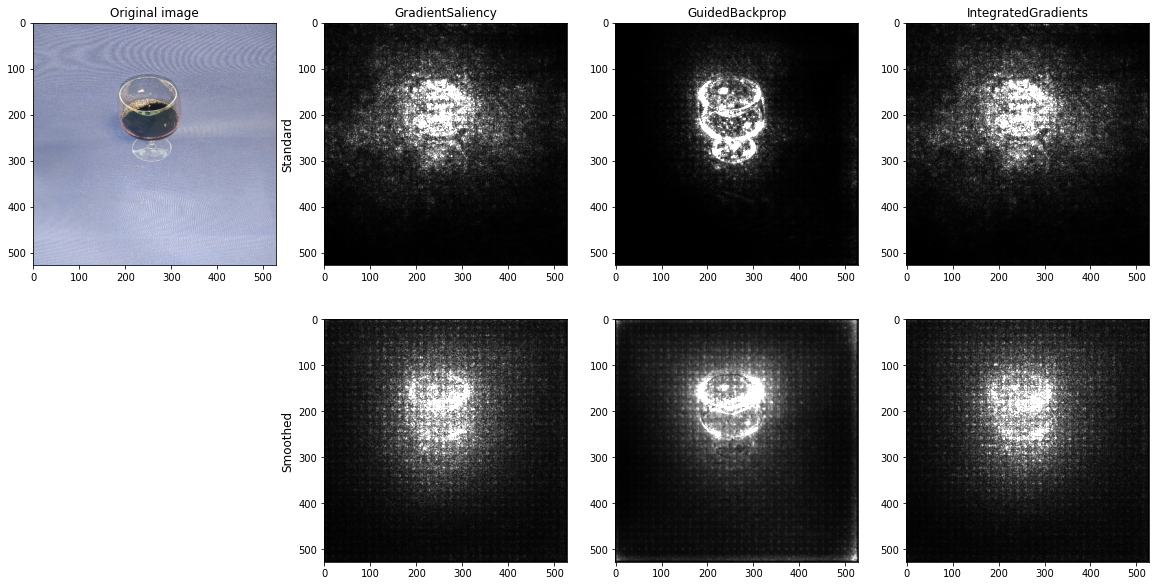

In [2]:
FILEPATH = '/srv/datos/Laboratorio/Madrid/copa Bor/Fondo azul/Est_Mad_J_Bor_200_nd_f_az_sin_me_sup.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/3] GradientSaliency
[2/3] GuidedBackprop


W0928 12:05:51.140820 140252693964608 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:60: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0928 12:06:04.801943 140252693964608 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:69: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.

W0928 12:06:04.804665 140252693964608 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:70: The name tf.train.export_meta_graph is deprecated. Please use tf.compat.v1.train.export_meta_graph instead.

W0928 12:06:05.325922 140252693964608 deprecation_wrapper.py:119] From /srv/image-classification-tf/imgclas/visualization/guided_backprop.py:72: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0928 12:06:08.515308 14025269396460

[3/3] IntegratedGradients
1/1 [==============================] - 7s 7s/step
Top predicted labels:
[43.3%] 300mL
[32.4%] 250mL


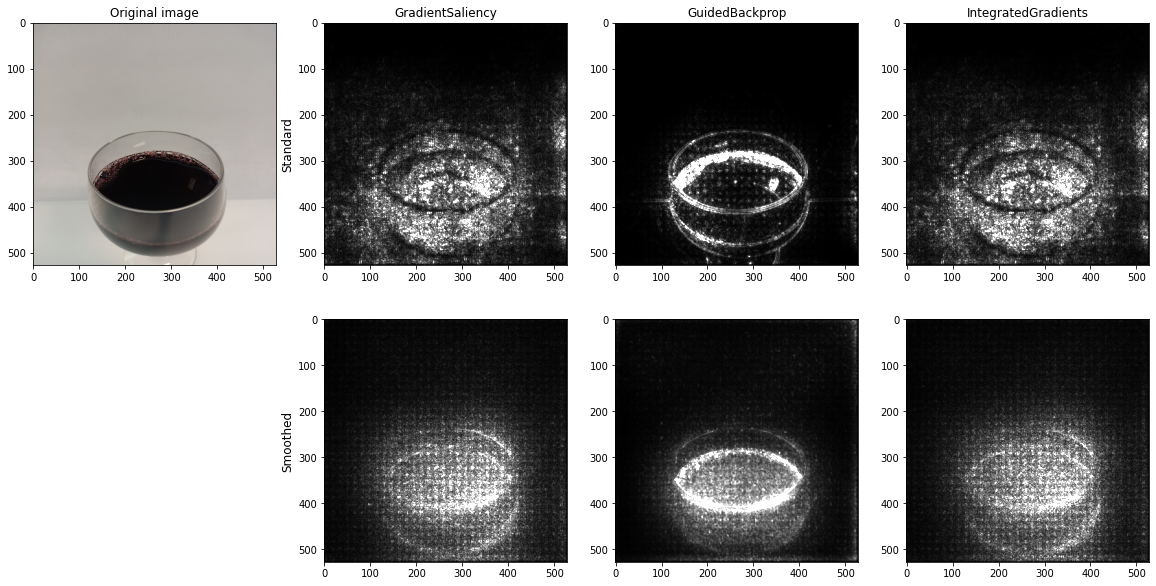

In [4]:
FILEPATH = '/srv/datos/Laboratorio/Madrid/copa Char/Fondo blanco/Est_Mad_J_Char_175_nd_nf_bl_sin_ce_sup.jpg'
saliency_types = [GradientSaliency, GuidedBackprop, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
axs = axs.T.flatten()

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
axs[0].imshow(image)
axs[0].set_title('Original image', fontsize=12)
fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
axs[0].set_ylabel('Standard', fontsize=12)
axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))